In [77]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
data_dir = "C:/Users/hosei/Documents/DataSets/PGSRB"
train_path = "C:/Users/hosei/Documents/DataSets/PGSRB/"
test_path = "C:/Users/hosei/Documents/DataSets/PGSRB/"


train_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/PGSRB/train_csv.csv')
test_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/PGSRB/test_csv.csv')

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [80]:
num_epochs = 2
batch_size = 64
learning_rate = 0.001

In [81]:
# Transforming the Data ToTensor and Normalize it + resize to 28*28

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((112,112))])

#creating the dataset class
class PRSM_DataSet(Dataset):
    def __init__(self, df, root_dir,transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.df.iloc[index,1])  #the column of paths in dataframe is 1
        image = Image.open(image_path)
        y_class = torch.tensor(self.df.iloc[index, 0]) #the column of ClsassId in daraframe is 0
        
        if self.transform:
            image = self.transform(image)
            return (image, y_class)

In [82]:
training_set = PRSM_DataSet(train_df,data_dir,transform=transforms)
test_set = PRSM_DataSet(test_df,data_dir,transform=transforms)

In [83]:
train_loader = DataLoader(dataset = training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'training':train_loader,'testing':test_loader}
dataset_sizes = {'training':len(train_loader.dataset),'testing':len(test_loader.dataset)}
print(dataset_sizes)

{'training': 53056, 'testing': 15000}


In [84]:
#creating the model
class PRSM_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(PRSM_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)

        # self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        # self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        # self.batchnorm3 = nn.BatchNorm2d(1024)
        # self.maxpool3 = nn.AdaptiveMaxPool2d(512)

        
        self.l1 = nn.Linear(200704,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_size)




    def forward(self,input):
        #training pipeline

        conv = self.conv1(input)
        conv = self.conv2(conv)

        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)

        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        # conv = self.conv5(maxpool)
        # conv = self.conv6(conv)
        # batchnorm = self.relu(self.batchnorm3(conv))
        # maxpool = self.maxpool3(batchnorm)
    

              
        flatten = self.flatten(maxpool)
        
        #Neural Network Featuremap input
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
    
        return output

In [86]:
input_size = 3*112*112
output_size = 18
model = PRSM_Model(input_size=input_size, output_size=output_size)
model.cuda()

PRSM_Model(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_features=200704, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=128, bias=True)
  (batchnorm4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l3): Linear(in_features=128, out_features=18, bi

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        # images, labels = images.type(torch.LongTensor), labels.type(torch.LongTensor)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            n_samples +=labels.shape[0]
            n_correct +=(predictions == labels).sum().item()
        acc = 100.0 * (n_correct / n_samples)
        print(f'epoch {epoch+1} / 10, accuracy = {acc}')

epoch 1 / 2, step 10, loss = 1.883663535118103
epoch 1 / 2, step 20, loss = 1.518661379814148
epoch 1 / 2, step 30, loss = 1.707715392112732
epoch 1 / 2, step 40, loss = 1.1421693563461304
epoch 1 / 2, step 50, loss = 1.328472375869751
epoch 1 / 2, step 60, loss = 1.192484736442566
epoch 1 / 2, step 70, loss = 1.2033143043518066
epoch 1 / 2, step 80, loss = 0.9934983849525452
epoch 1 / 2, step 90, loss = 1.0525782108306885
epoch 1 / 2, step 100, loss = 1.3368890285491943
epoch 1 / 2, step 110, loss = 0.8148147463798523
epoch 1 / 2, step 120, loss = 1.031439185142517
epoch 1 / 2, step 130, loss = 0.8221414089202881
epoch 1 / 2, step 140, loss = 1.0075539350509644
epoch 1 / 2, step 150, loss = 0.7576898336410522
epoch 1 / 2, step 160, loss = 0.6913971304893494
epoch 1 / 2, step 170, loss = 0.7163666486740112
epoch 1 / 2, step 180, loss = 0.5975338816642761
epoch 1 / 2, step 190, loss = 0.8598864674568176
epoch 1 / 2, step 200, loss = 0.8411740660667419
epoch 1 / 2, step 210, loss = 0.806

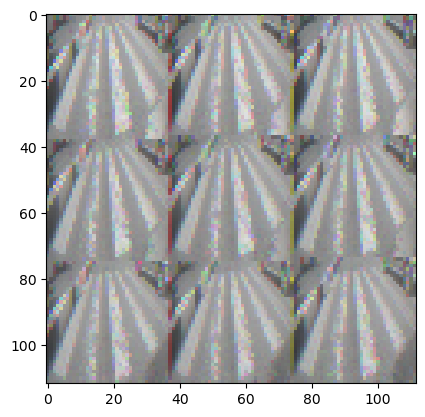

In [76]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]
image.shape 

# torch.Size([3, 28, 28]) # pyplot doesn't like this, so reshape

image = image.reshape(112,-1,3)
plt.imshow(image.numpy())